# Driven PXP Mode

We will use the `Optim.jl` package for auto-diff optimization, and the `EDKit.jl` for exact diagonalization calculation.

In [1]:
using EDKit, LinearAlgebra, Optim

In [2]:
const L = 20
const dt = 0.05

function pxpf(v::Vector{<:Integer}) 
    for i in eachindex(v)
        v[i]==0 && v[mod(i, length(v))+1]==0 && return false
    end
    true
end

# Evolution Ue for even-paraty sector
const evo1 = begin
    B1 = TranslationParityBasis(f=pxpf, L=L, k=0, p=1)
    P = [0 0; 0 1]
    PXP = kron(P, spin("X"), P)
    H0 = trans_inv_operator(PXP, 1:3, B1)
    E1, V1 = eigen(Hermitian(H0))
    V1 * Diagonal(exp.(-1im * dt * E1)) * V1'
end;

# Evolution Uo for odd-paraty sector
const evo2 = begin
    B2 = TranslationParityBasis(f=pxpf, L=L, k=L÷2, p=-1)
    H0 = trans_inv_operator(PXP, 1:3, B2)
    E2, V2 = eigen(Hermitian(H0))
    V2 * Diagonal(exp.(-1im * dt * E2)) * V2'
end;

In [3]:
const SN1 = trans_inv_operator([1 0;0 0], 1, B1) |> Array |> diag
const SN2 = trans_inv_operator([1 0;0 0], 1, B2) |> Array |> diag
const V01, V02 = vcat(1, zeros(size(B1,1)-1)), vcat(1, zeros(size(B2,1)-1))
"""
Δ = Δ₀ + Δ₁ cos(ωt) + Δ₂ cos(2ωt) + Δ₃ cos(3ωt) + Δ₄ cos(4ωt)
"""
function fidelity(params, T=100)
    v1, v2 = V01, V02
    N = round(Int, T/dt)
    map(1:N) do i
        f = params[2] 
        f += params[3] * cos(params[1] * i * dt) 
        f += params[4] * cos(params[1] * 2i * dt) 
        f += params[5] * cos(params[1] * 3i * dt) 
        f += params[6] * cos(params[1] * 4i * dt)
        v1 = exp.(-f*SN1*dt*1im) .* (evo1 * v1) 
        v2 = exp.(-f*SN2*dt*1im) .* (evo2 * v2) 
        abs(dot(V01, v1)+dot(V02, v2))^2 / 4
    end
end;

In [4]:
T=100
function loss(params)
    period = 2π/params[1]
    F = fidelity(params, T)
    M = floor(Int, T/(2*period))
    out = 1.0
    for i in 1:M 
        j1 = round(Int, 2i*period/dt) 
        j2 = round(Int, (2i-1)*period/dt)
        out -= (F[j1] - F[j2])/M
    end 
    out
end;

In [5]:
init_p = [2.72, 1.15, 2.67, 0., 0., 0.]
# The optimization code is:
# res = optimize(loss, init_p, BFGS(); autodiff = :forward).minimizer
# The following is the result:
res = [2.712188250074131, 1.244658202348191, 3.0357165151222536, 1.628636337215439, 5.04015853467762, -6.719927850497436]

6-element Vector{Float64}:
  2.712188250074131
  1.244658202348191
  3.0357165151222536
  1.628636337215439
  5.04015853467762
 -6.719927850497436

## Results

In [6]:
println("Loss function for 1st-order drive: $(loss(init_p))")
println("Loss function for 4th-order drive: $(loss(res))", )

Loss function for 1st-order drive: 0.05736331207216436


Loss function for 4th-order drive: 0.005601266361395192


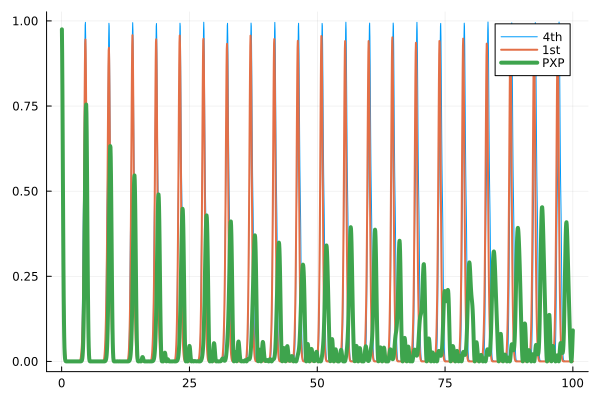

In [7]:
using Plots
t = 0.05:0.05:100
F0 = fidelity(zeros(6))
F1 = fidelity(init_p)
F4 = fidelity(res)
plot(t, F4, linewidth=1, label="4th")
plot!(t, F1, linewidth=2, label="1st")
plot!(t, F0, linewidth=4, label="PXP")